# Symbolic derivation of 1-D FEM stiffness matrix

First import everything. Note how we now import sympy as sy to make it clear which functions we are using

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from scipy.linalg import solve
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300



Now we define the symbols, compute the shape function, and build the stiffness matrix of a single elelemt.

In [27]:
# symbols
dx, x, k, xi, c = sy.symbols('dx x k xi c')
    
N1  = 1-x/(dx)
N2  = x/(dx)

E11 = sy.simplify(sy.integrate((N1*c*sy.diff(N1,x) + sy.diff(N1,x)*k*sy.diff(N1,x)), ( x, 0, dx)))
E12 = sy.simplify(sy.integrate((N1*c*sy.diff(N2,x) + sy.diff(N1,x)*k*sy.diff(N2,x)), ( x, 0, dx))) 
E21 = sy.simplify(sy.integrate((N2*c*sy.diff(N1,x) + sy.diff(N2,x)*k*sy.diff(N1,x)), ( x, 0, dx))) 
E22 = sy.simplify(sy.integrate((N2*c*sy.diff(N2,x) + sy.diff(N2,x)*k*sy.diff(N2,x)), ( x, 0, dx)))

Ael = sy.Matrix([[E11, E12], [E21, E22]])
Ael

Matrix([
[-c/2 + k/dx, c/2 - k/dx],
[-c/2 - k/dx, c/2 + k/dx]])

Note how we made a little simplification here and integrated from 0 to dx and not from x(i) to x(i+1); the result is the same.

Now we build the global stiffness matrix by adding all element stiffness matrices to the big global stiffness matrix. Unfortunately, the indexing in sympy matrices is a bit different to normal numpy indexing. 

We there have to use a little trick that is described here:
https://www.reddit.com/r/learnpython/comments/f7uxn6/question_how_to_add_matrix_to_submatrix_in_sympy/

We simply identify the upper left index on the left-hand side and use list indexing on the right-hand side when adding the small matrices to the big one.

In [24]:
# numerical paramters
nel     = 4       # number of elements
nnodel  = 2       # nodes per element 
nnod    = nel+1   # number of nodes

EL2NOD  = np.array([np.arange(1,nnod), np.arange(2,nnod+1)])  # connectivity matrix

# global matrix assemly
A = sy.zeros(nnod, nnod)
for iel in range(0,4):
    A[EL2NOD[0,iel]-1,EL2NOD[0,iel]-1] = A[list(EL2NOD[:,iel]-1), list(EL2NOD[:,iel]-1)] + Ael

A


Matrix([
[-c/2 + k/dx,  c/2 - k/dx,           0,           0,          0],
[-c/2 - k/dx,      2*k/dx,  c/2 - k/dx,           0,          0],
[          0, -c/2 - k/dx,      2*k/dx,  c/2 - k/dx,          0],
[          0,           0, -c/2 - k/dx,      2*k/dx, c/2 - k/dx],
[          0,           0,           0, -c/2 - k/dx, c/2 + k/dx]])

Does this matrix look familiar? Compare it to the FTCS solution - it's the same safe for a constant factor dx, which drops out because I also shows up on the RHS (if we had one)!

Ok let's implement it and compare it to the analytical solution!

<function matplotlib.pyplot.show(close=None, block=None)>

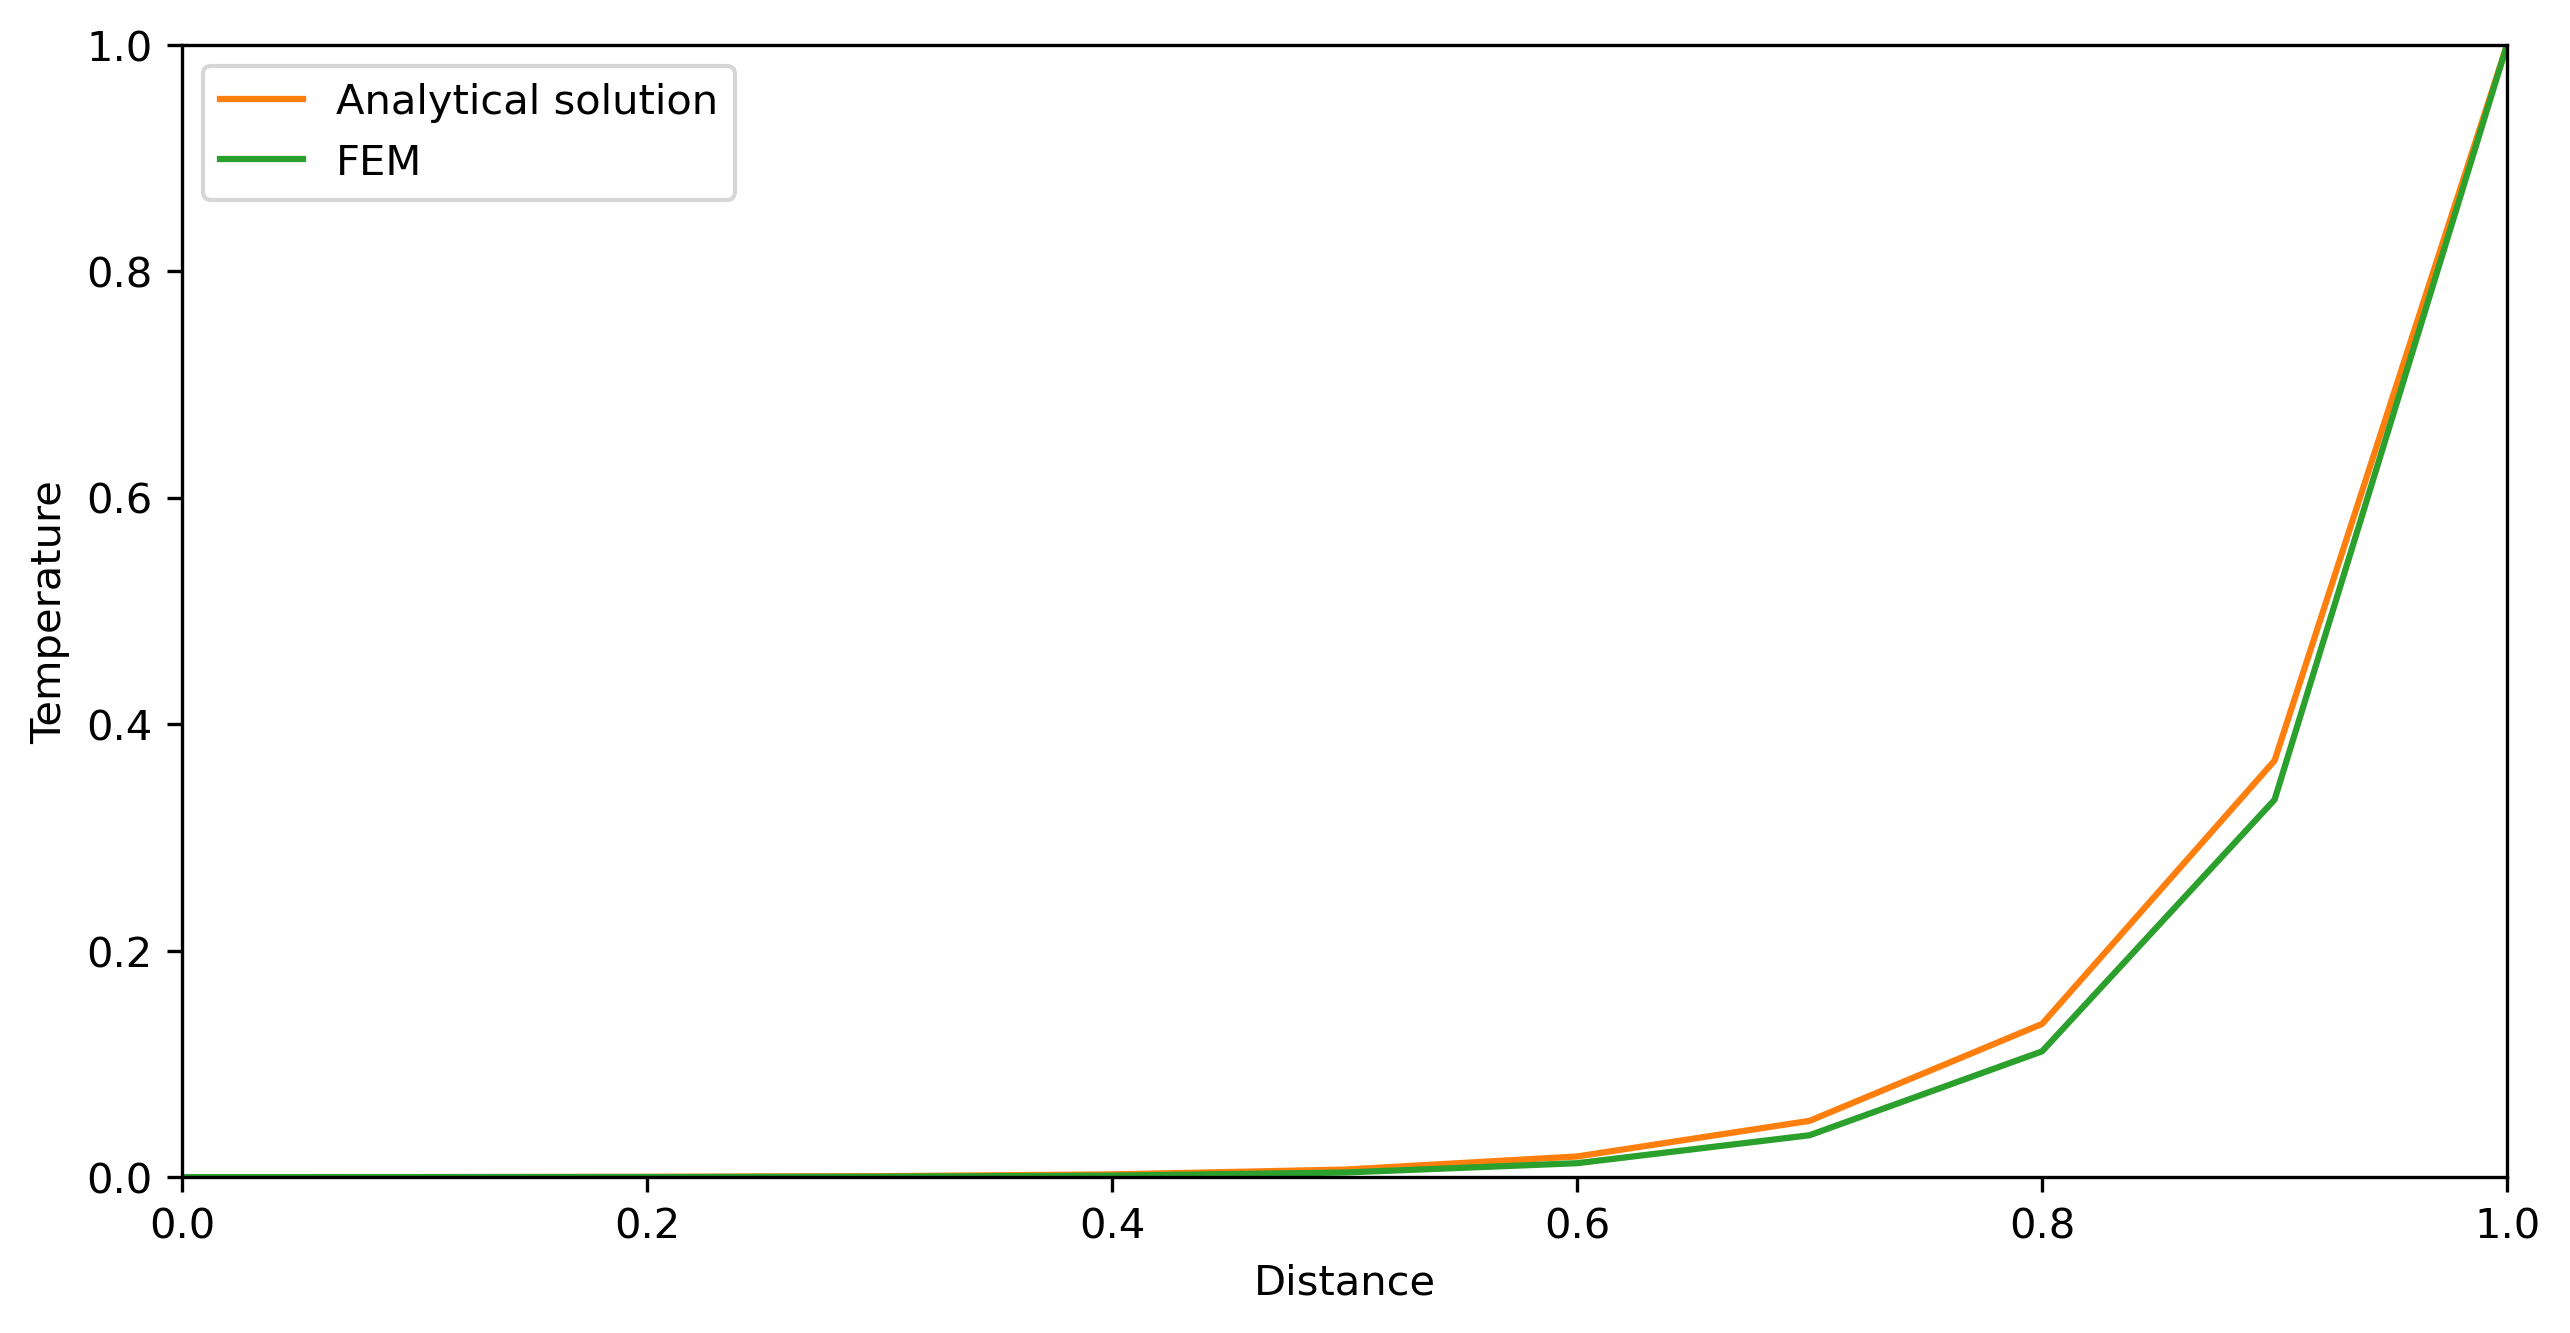

In [26]:
# model parameters
c       = 20
k       = 2
nx      = 11
x0      = 0
x1      = 1

Tleft   = 0
Tright  = 1

X,dx    = np.linspace(x0,x1, nx, retstep=True)

#peclet number for stability analysis
peclet  = c*dx/(2*k)

#analytical solution with boundary conditions T(0) = 0 and T(1) = 1;
C2      = 1/(1-np.exp(c/k))
C1      = -C2;
Tana    = C1*np.exp(c/k*X) + C2

# FEM solution
# build the coefficient matrix
data  = (np.ones((nx,1))*np.array([-(c/(2) + k/dx), (2*k/dx), -(-c/(2)+k/dx) ])).T
diags = np.array([-1, 0, 1])
A     = spdiags(data, diags, nx, nx).toarray()

# and add boundary conditions
A[0,0]       = 1
A[0,1]       = 0
A[nx-1,nx-1] = 1
A[nx-1,nx-2] = 0
Rhs          = np.zeros(nx)
Rhs[0]       = Tleft
Rhs[-1]       = Tright
Tfem=solve(A,Rhs)


# plot everything

fig = plt.figure(figsize=(10,5))
fig.clf()
ax  = plt.axes(xlim=(x0, x1), ylim=(Tleft, Tright))
line, = ax.plot([], [], lw=1)
ax.set_xlabel('Distance')
ax.set_ylabel('Temperature')
plt.plot(X, Tana, label='Analytical solution')
plt.plot(X, Tfem, label='FEM')

plt.legend()

plt.show

